# extract information from `.out` files



In [1]:
import os
import rootutils
rootutils.setup_root(  # setup project root
    # search_from=__file__,  # for .py files
    search_from=os.getcwd(),  # for .ipynb files
    indicator=[".env", ".git", ],
    dotenv=True,  # load .env file to environment
    pythonpath=True,  # add root dir to PYTHONPATH
    cwd=True,  # change working directory to PROJECT_ROOT
)

PROJECT_ROOT = os.environ["PROJECT_ROOT"]
os.getcwd()

'/home/louzekun/orca_cal/orca_workflow'

In [2]:
import re
import csv
import pandas
from tqdm import tqdm


I use github copilot, to just paste the output example in the cell and let the copilot do the rest.


In [3]:
"""
infomation to extract:
raw:
```
|  2> %PAL NPROC 52 END
Number of atoms                             ...      9
Number of basis functions                   ...    192
Number of shells                            ...     84
Maximum angular momentum                    ...      3
Triples Correction (T)                     ...     -0.013072999
Final correlation energy                   ...     -0.414534966
E(CCSD)                                    ...    -79.660833025
E(CCSD(T))                                 ...    -79.673906023
FINAL SINGLE POINT ENERGY      -111.238840552281
TOTAL RUN TIME: 0 days 0 hours 1 minutes 8 seconds 617 msec
```
"""
# for each line, write the regex to extract the value
out_regex = {
    "NPROC": r"NPROC (\d+) END",
    "Number of atoms": r"Number of atoms\s+\.\.\.\s+(\d+)",
    "Number of basis functions": r"Number of basis functions\s+\.\.\.\s+(\d+)",
    "Number of shells": r"Number of shells\s+\.\.\.\s+(\d+)",
    "Triples Correction (T)": r"Triples Correction \(T\)\s+\.\.\.\s+(-?\d+\.\d+)",
    "Final correlation energy": r"Final correlation energy\s+\.\.\.\s+(-?\d+\.\d+)",
    "E(CCSD)": r"E\(CCSD\)\s+\.\.\.\s+(-?\d+\.\d+)",
    # "E(CCSD(T))": r"E\(CCSD\(T\)\)\s+\.\.\.\s+(-?\d+\.\d+)",  # same as final spe
    "Maximum angular momentum": r"Maximum angular momentum\s+\.\.\.\s+(\d+)",
    "FINAL SINGLE POINT ENERGY": r"FINAL SINGLE POINT ENERGY\s+(-?\d+\.\d+)",
    "TOTAL RUN TIME": r"TOTAL RUN TIME: (\d+ days \d+ hours \d+ minutes \d+ seconds \d+ msec)",
}


In [4]:
# get output file paths

out_dpath = os.path.join(PROJECT_ROOT, "out")

# iterate over the out files, find all the regex_str, and write to a csv file
out_each_dpaths = [os.path.join(out_dpath, d) for d in os.listdir(out_dpath)
                   if os.path.isdir(os.path.join(out_dpath, d))]
out_fpaths = []
for out_each_dpath in tqdm(out_each_dpaths):
    if not "finished" in os.listdir(out_each_dpath):
        continue  # not finished
    # the out file is a file ends with .out
    out_file = [f for f in os.listdir(out_each_dpath) if f.endswith(".out")]
    assert len(out_file) == 1
    out_file = out_file[0]
    out_fpaths.append(os.path.join(out_each_dpath, out_file))

len(out_fpaths), out_fpaths[0:3]

100%|██████████| 9/9 [00:00<00:00, 19388.15it/s]


(7,
 ['/home/louzekun/orca_cal/orca_workflow/out/0698/0698.out',
  '/home/louzekun/orca_cal/orca_workflow/out/3380/3380.out',
  '/home/louzekun/orca_cal/orca_workflow/out/3891/3891.out'])

In [30]:
# extract output info

def extract_info(out_file):
    with open(out_file, "r") as f:
        out_str = f.read()
    # get out_file file name
    out_fname = os.path.basename(out_file)
    name = out_fname[:-4]  # remove .out
    info = {"name": name}
    for key, regex in out_regex.items():
        match = re.search(regex, out_str)
        if match is None:
            print("Error: {} not found in {}".format(key, out_file))
            return None
        info[key] = match.group(1)
    # for total run time, convert into seconds
    regex = r"(\d+) days (\d+) hours (\d+) minutes (\d+) seconds (\d+) msec"
    match = re.search(regex, info["TOTAL RUN TIME"])
    convert_cum = [24*3600, 3600, 60, 1, 1e-3]
    info["runtime"] = sum([int(match.group(i+1))*convert_cum[i] for i in range(5)])
    # info["runtime"] = round(info["runtime"], 3)
    info["walltime"] = info["runtime"] * int(info["NPROC"])
    return info

def write_csv(out_files, csv_file):
    with open(csv_file, "w") as f:
        writer = csv.writer(f)
        writer.writerow(["out_file"] + list(out_regex.keys()))
        for out_file in out_files:
            info = extract_info(out_file)
            if info is None:
                continue
            writer.writerow([out_file] + [info[key] for key in out_regex.keys()])



out_infos = []
for out_fpath in tqdm(out_fpaths):
    info = extract_info(out_fpath)
    if info is None:
        continue
    out_infos.append(info)

# convert into pandas df
df = pandas.DataFrame(out_infos)
# remove total run time
df = df.drop(columns=["TOTAL RUN TIME"])
# sort by name
df = df.sort_values(by=["name"])
# turn colname to lower case
df.columns = [col.lower() for col in df.columns]

df.head()


100%|██████████| 9/9 [00:00<00:00, 1809.80it/s]


,name,nproc,number of atoms,number of basis functions,number of shells,triples correction (t),final correlation energy,e(ccsd),maximum angular momentum,final single point energy,runtime,walltime
0,0698,50,18,702,222,-0.048368841,-1.298320194,-272.554763987,4,-272.603132827967,753.840,37692.000
1,1334,52,15,639,199,-0.062436310,-1.379736203,-304.259858244,4,-304.322294553909,521.108,27097.616
2,3380,52,15,639,199,-0.058793742,-1.365972056,-308.053775112,4,-308.112568854140,555.136,28867.072
3,3552,50,11,519,159,-0.063491202,-1.393621261,-342.773457545,4,-342.836948746345,559.531,27976.550
4,3891,54,16,669,209,-0.060976677,-1.455033020,-325.318297567,4,-325.379274243402,644.558,34806.132


In [ ]:

# save to csv and pkl
df.to_csv(os.path.join(PROJECT_ROOT, "notebooks", "orca_out.csv"), index=False)
df.to_pickle(os.path.join(PROJECT_ROOT, "notebooks", "orca_out.pkl"))


/tmp/ipykernel_205992/2470484645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_time[c] = compare_time[c].astype(float)


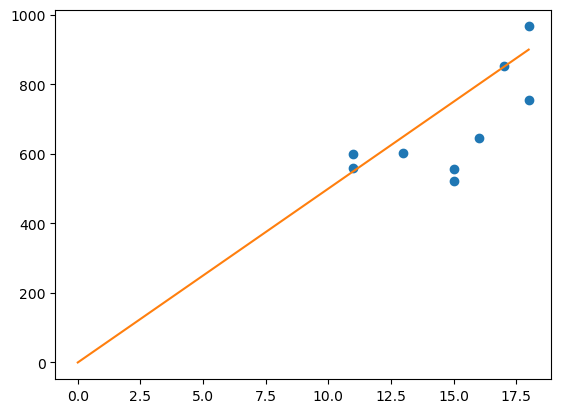

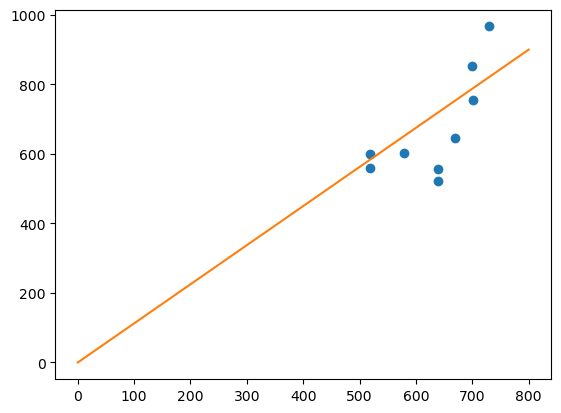

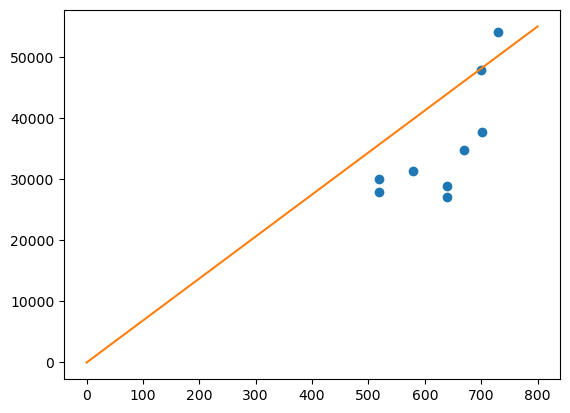

In [47]:
import matplotlib.pyplot as plt

compare_columns = ['name', 'number of atoms', 'number of basis functions', 'runtime', 'walltime']

compare_time = df[compare_columns]
for c in compare_columns:
    if c == 'name':
        continue
    else:
        compare_time[c] = compare_time[c].astype(float)

compare_time = compare_time.sort_values('number of atoms')
plt.plot(compare_time["number of atoms"], compare_time["runtime"], "o")
plt.plot([0,18], [0,900])
plt.show()

compare_time = compare_time.sort_values('number of basis functions')
plt.plot(compare_time["number of basis functions"], compare_time["runtime"], "o")
plt.plot([0,800], [0,900])
plt.show()

compare_time = compare_time.sort_values('number of basis functions')
plt.plot(compare_time["number of basis functions"], compare_time["walltime"], "o")
plt.plot([0,800], [0,55000])